## Histone deacetylase 1 - part 3 (rule aggregation)

### Import libraries

In [1]:
import pandas as pd

### Read in the datasets

In [2]:
df = pd.read_csv('hdac1_inhibitors_stripped.csv')
df_pairs = pd.read_csv('hdac1_inhibitors_pairs.csv')

### Determine which measurements can be included in delta property calculation

In [3]:
df['pchembl_exact'] = df.apply(lambda x: x.pchembl_value if x.standard_relation == "=" and x.pchembl_value else None, axis=1)

### Combine twice with confirmed molecular pairs

In [4]:
df_merge = df_pairs.merge(df, left_on='smiles1', right_on='stripped_smiles')
df_merge = df_merge.merge(df, left_on=['smiles2', 'assay_chembl_id'], right_on=['stripped_smiles', 'assay_chembl_id'])
df_merge['pchembl_exact_delta'] = df_merge['pchembl_exact_y'] - df_merge['pchembl_exact_x'] 
df_merge.sample(3).transpose()

,1627,1246,1129
smiles1,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2cccc...
smiles2,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
percentmcs,0.75,0.69697,0.787879
radius,3.0,2.0,4.0
valid,True,True,True
...,...,...,...
ligand_efficiency.bei_y,NaN,18.18,NaN
ligand_efficiency.le_y,NaN,0.33,NaN
stripped_smiles_y,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
pchembl_exact_y,NaN,8.01,6.43


### Filter mcs > 90%

In [5]:
df_agg = df_merge[(df_merge.percentmcs > 0.9) & pd.notna(df_merge.pchembl_exact_delta)]

### Aggregate data by the two fragments

In [6]:
indexcols = ['fragment1', 'fragment2', 'radius', 'assay_chembl_id']
df_agg_data = pd.pivot_table(df_agg, values='pchembl_exact_delta', index=indexcols, aggfunc=['count','mean'])
df_agg_data.columns = ['_'.join(col).strip() for col in df_agg_data.columns.values]

### Retain single SMIRKS per transformation (effectively at random)

In [7]:
df_agg_smirks = pd.pivot_table(df_agg, values='smirks', index=indexcols, aggfunc='first')
df_agg = df_agg_data.join(df_agg_smirks).reset_index()

### Write to file

In [8]:
df_agg.to_csv('hdac1_inhibitors_transformations.csv', index=False)

### ...and finally plot (figure 3 from wizepairz paper)

In [9]:
df_plot = df_agg[df_agg.radius == 3]
df_plot = pd.pivot_table(df_plot, values='mean_pchembl_exact_delta', index=['fragment1', 'fragment2', 'radius'], columns='assay_chembl_id', aggfunc='first')
df_plot

assay_chembl_id                                                                             CHEMBL927948  \
fragment1                                 fragment2                                 radius                 
[CH3][CH2][N]([CH2][CH3])[CH2][CH3]       [CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] 3.0         0.016667   
[CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] [CH3][CH2][N]([CH2][CH3])[CH2][CH3]       3.0        -0.016667   
[cH2][cH][c]([CH3])[c](-[cH3])[nH]        [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.293333   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0         0.110000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.305000   
[cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0        -0.293333   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0        -0.160000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.605000   
[cH2][cH][c]([Cl])[c](-[cH3])[nH]         [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0        -0.110000   
                                          [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.160000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.400000   
[cH2][cH][c]([F])[c](-[cH3])[nH]          [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0         0.305000   
                                          [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.605000   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0         0.400000   

assay_chembl_id                                                                             CHEMBL927949  \
fragment1                                 fragment2                                 radius                 
[CH3][CH2][N]([CH2][CH3])[CH2][CH3]       [CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] 3.0         0.003333   
[CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] [CH3][CH2][N]([CH2][CH3])[CH2][CH3]       3.0        -0.003333   
[cH2][cH][c]([CH3])[c](-[cH3])[nH]        [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.266667   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0        -0.140000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.255000   
[cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0        -0.266667   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0        -0.365000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.545000   
[cH2][cH][c]([Cl])[c](-[cH3])[nH]         [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0         0.140000   
                                          [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.365000   
                                          [cH2][cH][c]([F])[c](-[cH3])[nH]          3.0        -0.320000   
[cH2][cH][c]([F])[c](-[cH3])[nH]          [cH2][cH][c]([CH3])[c](-[cH3])[nH]        3.0         0.255000   
                                          [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0         0.545000   
                                          [cH2][cH][c]([Cl])[c](-[cH3])[nH]         3.0         0.320000   

assay_chembl_id                                                                             CHEMBL927950  \
fragment1                                 fragment2                                 radius                 
[CH3][CH2][N]([CH2][CH3])[CH2][CH3]       [CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] 3.0             0.07   
[CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3] [CH3][CH2][N]([CH2][CH3])[CH2][CH3]       3.0            -0.07   
[cH2][cH][c]([CH3])[c](-[cH3])[nH]        [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]      3.0              NaN   
  

<AxesSubplot:xlabel='CHEMBL927952', ylabel='CHEMBL927948'>

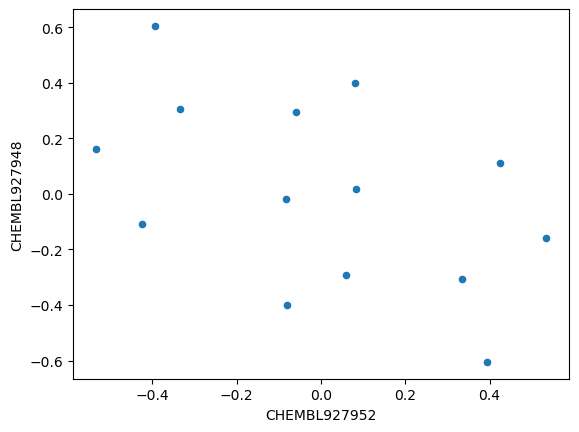

In [10]:
%matplotlib inline
df_plot.plot.scatter('CHEMBL927952', 'CHEMBL927948')